# Problem 2: A twist on k-means

In this problem, you will be asked to create a twice-modified version of the k-means clustering algorithm. The modifications you will make will test your ability to implement a machine learning algorithm you may not have seen before, and also to reason through an abstract problem that is not easy to visualize.

The first change we will make from k-means is to generalize it. The clusters will not be restricted to circular shape; rather, each cluster will be permitted to have its own center _and_ dispersion (a measure of the "spread" of the cluster), which can vary by dimension. The second change we will make will be to allow higher dimensionality than the two dimensions easily visible on your computer screen. There is no code to graph your final results here (though we're happy to provide some after the exam upon request).

## Background: The multivariate normal distribution

Recall that a _normally distributed_ (or _Gaussian_) random variable with mean value $\mu$ and variance $\sigma^2$ has a probability distribution function (PDF) of the form,

$$
  f(x; \mu, \sigma^2) \equiv \frac{1}{\sigma \sqrt{2 \pi}} \exp\!\left[- \frac{1}{2} \frac{(x - \mu)^2}{\sigma^2}\right].
$$

As a reminder, here is a plot of that function where $\mu = 1.5$ and $\sigma^2 = 0.25$ (i.e., $\sigma = 0.5$). To evaluate this function, we are using Scipy's built-in [`scipy.stats.norm()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html).

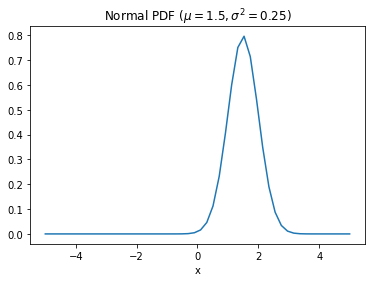

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def normal_pdf(x, mu=0, sigma2=1): # sigma2 == sigma-squared!
    from scipy.stats import norm
    from math import sqrt
    return norm.pdf(x, loc=mu, scale=sqrt(sigma2))

import numpy as np
x_values = np.linspace(-5, 5, 50)
plt.plot(x_values, normal_pdf(x_values, mu=1.5, sigma2=0.25))
plt.xlabel('x')
plt.title('Normal PDF ($\mu=1.5, \sigma^2=0.25$)');

That example is one-dimensional since $x$ is a scalar. This 1-D concept can be generalized to higher dimensions via the the **_multivariate normal_** distribution, which we now summarize.

**Multivariate normal in $d$ dimensions.** Let $\hat{\mathbf{x}}$ be a $d$-dimensional vector. The multivariate normal distribution has a $d$-dimensional mean _vector_ $\mathbf{m}$ and a $d \times d$ _covariance matrix_ $\Sigma$. It is a probability distribution, so it has a PDF. The formula for the PDF is given by
$$
  g(\hat{\mathbf{x}}; \mathbf{m}, \Sigma) \equiv \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}} \exp\!\left[-\frac{1}{2} (\hat{\mathbf{x}} - \mathbf{m})^T \Sigma^{-1} (\hat{\mathbf{x}} - \mathbf{m})\right],
$$
where $\det \Sigma$ is the _determinant_ of $\Sigma$. (You probably saw determinants in a linear algebra class, where you might have learned to interpret it as measuring how much a linear transformation $\Sigma$ will "stretch" a volume.)

As with the 1-D normal distribution, Scipy provides a function to evaluate the PDF of the multivariate normal, given $\hat{\mathbf{x}}$, $\mathbf{m}$, and $\Sigma$.

**Exercise 0** (1 point). Read the code for `multivariate_normal_pdf` and convince yourself that it allows you to evaluate the function $g(\cdot)$ defined above. In this process, consult the documentation for [`scipy.stats.multivariate_normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html) as needed.

> This exercise is a "freebie." You don't need to write any code, but you should do your best to understand the code you are given below.

In [4]:
def multivariate_normal_pdf(x_vec, m_vec=0, Sigma_mat=1):
    from scipy.stats import multivariate_normal
    return multivariate_normal.pdf(x_vec, m_vec, Sigma_mat)

# Define some mean vector and covariance
mean_vec = np.array([1.5, -2.0])
Sigma = np.array([[1.25, 0.5],
                  [0.5, 4.0]])

print(multivariate_normal_pdf([0.0, 0.0], mean_vec, Sigma))
print(multivariate_normal_pdf(mean_vec, mean_vec, Sigma))

0.012198734530353557
0.07302529613710936


Assuming you were "successful" in completing Exercise 0 above, you should be able to understand the plotting code below, which uses techniques that you saw in Notebook 12, Part 1. Run it now, look at the output, and then quickly scan the code to get an idea of what it is doing.

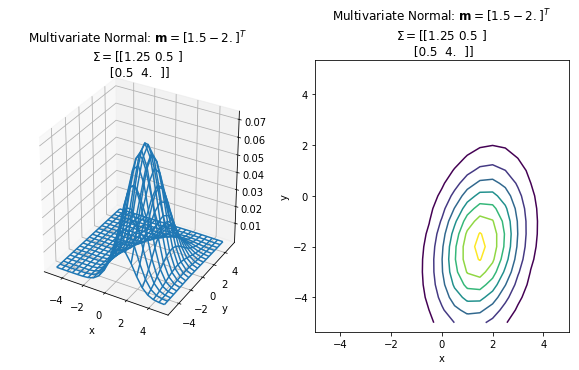

In [5]:
# Create a 2-D coordinate grid.
# Each pair (x_coords[j], y_coords[i]) is some point in this grid
x_coords = np.linspace(-5, 5, 21)
y_coords = np.linspace(-5, 5, 21)

# For each of these points, evaluate the PDF g(x_hat, mu, Sigma):
X_coords, Y_coords = np.meshgrid(x_coords, y_coords)
Z_values = np.empty((len(x_coords), len(y_coords)))
for j, yj in enumerate(y_coords):
    for i, xi in enumerate(x_coords):
        x_hat = np.array([xi, yj])
        Z_values[j, i] = multivariate_normal_pdf(x_hat, mean_vec, Sigma)

# Create a plot of this multivariate (2-D) distribution.
# It should look like a 2-D version of a 1-D bell curve
# corresponding to the normal distribution.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 5))

ax3d = fig.add_subplot(121, projection='3d')
ax3d.plot_wireframe(X_coords, Y_coords, Z_values)
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
m_latex = r'$\mathbf{{m}}={}^T$'.format(mean_vec)
Sigma_latex = r'{}'.format(Sigma)
ax3d.set_title('Multivariate Normal: {}\n$\Sigma=${}'.format(m_latex, Sigma_latex))

ax2d = fig.add_subplot(122)
ax2d.contour(X_coords, Y_coords, Z_values)
ax2d.set_xlabel('x')
ax2d.set_ylabel('y')
ax2d.axis('equal')
ax2d.set_title('Multivariate Normal: {}\n$\Sigma=${}'.format(m_latex, Sigma_latex))
pass;

## A synthetic dataset

For the rest of this problem, we will need a synthetic multidimensional dataset, which you will then cluster using a variation on k-means.

Run the code cell below to create the dataset. It specifically constructs a data matrix, `X`, that follows our usual storage convention, namely, observations as rows and predictors or features as columns.

For the moment, you can just run the cell. We will explain what it creates as needed in subsequent parts.

In [6]:
import numpy.random as nprand
import numpy as np
import numpy.linalg as nplinalg

np.set_printoptions(precision=8)

# Establish constants - original is 170/4/400/5
nprand.seed(170)
nclusters=4
npoints=400
nvars=5

npoints_per_cluster=[]
for i in range(nclusters):
    if i==nclusters-1:
        npoints_per_cluster.append(npoints-sum(npoints_per_cluster))
    else:
        remaining=npoints-sum(npoints_per_cluster)
        npoints_per_cluster.append(nprand.randint(1,remaining))
assert sum(npoints_per_cluster)==npoints

# Generate random points
X=np.zeros((npoints,nvars))
mus_true=np.zeros((nclusters,nvars))
sigmas_true=np.zeros((nclusters,nvars,nvars))
for i in range(nvars):
    x=np.array([])
    for c in range(nclusters):
        new=nprand.normal(nprand.uniform(-10000,10000),nprand.uniform(0,1000),npoints_per_cluster[c])
        x=np.append(x,new)
        mus_true[c,i]=np.sum(new)/npoints_per_cluster[c]
    X[:,i]=x
for c in range(nclusters):
    if c==0:
        prev_index=0
    else:
        prev_index=int(sum(npoints_per_cluster[0:c-1]))
    current_index=int(sum(npoints_per_cluster[0:c+1]))
    sigmas_true[c]=((X[prev_index:current_index,:]-mus_true[c]).T.dot((X[prev_index:current_index,:]-mus_true[c])))/npoints_per_cluster[c]

pi_true=np.array([i/npoints for i in npoints_per_cluster])

# Little fix to help convergence happen
cov_mod=1e-5*np.identity(nvars)

# Make randomized cluster seeds
mus=np.array([i.T for i in nprand.uniform(-10000,10000,(nclusters,nvars))])
sigmas=np.zeros((nclusters,nvars,nvars))
for i in range(len(sigmas)):
    s=nprand.uniform(0,100000,(nvars,nvars))
    sigmas[i]=(s.dot(s.T))
pis=np.array([1/nclusters]*nclusters)

print("Synthetic synthesis synthesized. (Ready for the next part!)")

Synthetic synthesis synthesized. (Ready for the next part!)


**Exercise 1** (1 point). Suppose that instead of a single point you are given a data matrix $X$ that holds $n$ points (rows), each of which is $d$-dimensional. That is, start by thinking of each row of $X$ as a (row) vector by our usual convention:

$$
  X \equiv \left[\begin{matrix} \hat{\mathbf{x}}_0^T \\ \hat{\mathbf{x}}_1^T \\ \vdots \\ \hat{\mathbf{x}}_{n-1}^T \end{matrix}\right].
$$

Implement a function, `multivariate_dist(X, m, Sigma)`, which returns a 1-D Numpy array of length $n$ containing the value of the multivariate normal PDF, $g$, evaluated at each point in $X$. Then, suppose we execute
```python
    y = multivariate_dist(X, m, Sigma)
```
Each `y[i]` should be the multivariate normal evaluated at point `X[i, :]` for the given mean vector `m` and covariance matrix `Sigma`.

In [7]:
def multivariate_dist(X, m_vec, Sigma):
    return multivariate_normal_pdf(X, m_vec=m_vec, Sigma_mat=Sigma)


In [8]:
#test cell

#test a few actual values of multivariate_dist
probs_student=np.array([multivariate_dist(X,mus[0],sigmas[0]),
                        multivariate_dist(X,mus[1],sigmas[1]),
                        multivariate_dist(X,mus[2],sigmas[2])]).T

#test shape
assert probs_student[:,0].shape==(npoints,), "Your output has the wrong shape."

md_test=probs_student[0:10]
md_true=[[2.50608557e-26,6.43323175e-27,4.58070225e-26]
,[2.62386636e-26,6.57027974e-27,4.58603458e-26]
,[2.63929812e-26,6.43248967e-27,5.19753240e-26]
,[2.53996465e-26,6.44368510e-27,4.73855971e-26]
,[2.46331420e-26,6.30637520e-27,4.93177338e-26]
,[2.52884304e-26,6.47681593e-27,4.49177977e-26]
,[2.52214451e-26,6.44917343e-27,4.69432336e-26]
,[2.57656669e-26,6.39547276e-27,5.13731435e-26]
,[2.42491429e-26,6.38723596e-27,4.37811774e-26]
,[2.54309342e-26,6.50265017e-27,4.46588976e-26]]
assert np.all(np.isclose(md_test,md_true)), "Your output isn't close to the correct values."

#test more values using hashing to conceal the entirety of the correct output
md_mod_test=np.apply_along_axis((lambda a: (round(a[0]*10e32)*round(a[1]*10e32))%round(a[2]*10e32)), 1, probs_student)
md_mod_test_true=np.array([4.3556458e+07,4.5824518e+07,2.4211822e+07,2.4719748e+07,4.8506852e+07
,2.4822690e+07,1.2831970e+06,7.4821220e+06,2.2797609e+07,2.4162460e+06
,2.1557294e+07,3.0007400e+07,1.1445663e+07,1.4697597e+07,2.9744241e+07
,2.8690000e+04,2.8182970e+06,4.0311632e+07,1.1406634e+07,3.2732120e+07
,2.9577366e+07,1.6319753e+07,2.0976997e+07,2.4344543e+07,3.3541800e+06
,3.4156364e+07,3.2178881e+07,2.6557226e+07,3.5239906e+07,3.6118120e+06
,2.3989971e+07,2.3160614e+07,4.3356070e+06,4.6528467e+07,3.3029648e+07
,3.8818752e+07,2.5648078e+07,1.8344593e+07,8.2539030e+06,1.7242250e+06
,1.3543104e+07,1.5745935e+07,7.6930300e+06,1.4012081e+07,2.5114944e+07
,1.1883753e+07,1.4815700e+06,1.0817455e+07,7.8231660e+06,1.1772571e+07
,6.6841650e+06,2.2666446e+07,4.6073650e+06,2.6090485e+07,3.3891830e+06
,2.3687552e+07,3.1143800e+05,2.4636059e+07,1.5924630e+07,2.1367460e+07
,1.9270454e+07,4.5910900e+06,1.1401587e+07,2.5635962e+07,2.3453956e+07
,2.1741664e+07,2.5955188e+07,2.4692136e+07,1.1996154e+07,2.6151852e+07
,1.9901073e+07,1.7337670e+07,2.6077120e+07,1.4063806e+07,1.3490268e+07
,2.5061736e+07,2.4180052e+07,1.5835393e+07,1.0079400e+06,1.0765625e+07
,2.3004959e+07,2.2989080e+06,1.4371803e+07,2.1579910e+06,7.8213240e+06
,4.4028100e+05,1.5207192e+07,2.2988936e+07,1.4899697e+07,2.5976516e+07
,1.3962429e+07,1.7459310e+07,9.9674680e+06,1.7042787e+07,9.5345080e+06])
assert np.all(np.equal(md_mod_test[0:95],md_mod_test_true)), "Your output contains incorrect values."

print("Passed!")

Passed!


## A kindler, gentler k-means

Now for the heart of this problem, which is to have you implement a variation of the k-means method you saw in one of the notebook assignments.

Recall that k-means does a "hard" assignment of points to clusters, meaning every point is assigned to one cluster. Here, let's see how we can instead do a "soft" assignment, where each point belongs _with some probability_ to each cluster. Roughly speaking, our formal model has these components:

1. Let $X$ be the $n \times d$ data matrix of $n$ observations, each of which is $d$-dimensional.
2. Suppose there are $c$ clusters.
3. Suppose we model each cluster $j$ ($0 \leq j < c$) by a multivariate normal distribution having an _unknown_ mean $\hat{\mathbf{m}}_j$ and covariance $\Sigma_j$.
4. There is also an _unknown_ prior probability $\pi_j$ that a point belongs to cluster $j$.

Our goal is to estimate ("learn") the unknown parameters, $\hat{\mathbf{m}}_j$, $\Sigma_j$, and $\pi_j$.

> Put differently, we assume that the following stochastic process generated the original data. First, we selected a cluster at random according to the probabilities $\{\pi_j\}$. Having picked one of the clusters, $j$, we then generated the point from that cluster according to its multivariate normal (mean $\hat{\mathbf{m}}_j$, covariance $\Sigma_j$). We carried out this process $n$ times, resulting in the $n$ data points.

So given the data $X$, how do we estimate all the cluster parameters? It turns out we can use maximum likelihood estimation, which is (effectively) what the remaining exercises have you do!

**Cluster assignment matrix.** For each cluster $j$ ($0 \leq j < c$), suppose the mean and covariance are given by $\hat{\mathbf{m}}_j$ and $\Sigma_j$, respectively. Also suppose that the prior probability that a point belongs to cluster $j$ is $\pi_j$. We would like to estimate the probability that some point $\hat{\mathbf{x}}$ belongs to each cluster $j$.

To do that, let's use the multivariate normal PDF, $g(\cdot)$. In particular, for each data point $\hat{\mathbf{x}}_i$, compute the probability that it belongs to cluster $j$ by the formula,

$$
  r_{i,j} \equiv \frac{g(\hat{\mathbf{x}}_i; \hat{\mathbf{mu}}_j, \Sigma_j) \cdot \pi_j}{Z_{i}}
$$

where $Z_i$ is a normalization constant. We need $Z_i$ to have a value that ensures, for all $i$, that $\sum_j r_{i,j} = 1$, i.e., that the cluster membership probabilities sum to 1. The matrix $R = \left[r_{i,j}\right]$ of these probabilities is the (soft) _cluster assignment_ matrix.

**Exercise 2** (2 points). Implement the function,
```python
    def update_r(X, mus, Sigmas, pis):
```
so that it returns the cluster assignment matrix, `R`, as a Numpy array. In particular:

* `X` is a `n`-by-`d` array, where each data point `i` is given by `X[i, :]`.
* `m_vecs` is a `c`-by-`d` array of cluster means, where `m_vecs[j, :]` is the mean $\hat{\mathbf{m}}_j$ of cluster `j`.
* `Sigmas` is a `c`-by-`d`-by-`d` array of cluster covariances, where `Sigmas[j, :, :]` is the covariance matrix $\Sigma_j$ of cluster `j`.
* `pis` is an array of length `c`, where `pis[j]` is $\pi_j$.
* `R` is a `n`-by-`c` array, where `R[i, j]` is $r_{i,j}$.

> There is a small helper function, `assert_dims_match()`, which is used to check that `X`, `m_vecs`, `Sigmas`, and `pis` have compatible dimensions. If so, it returns a triple `(n, d, c)` of the dimensions being used. If not, it will assert with an error. We will use it for testing, but if you encounter bugs, you may find it helpful to check whether the inputs you are processing are correct.

In [21]:
def assert_dims_match(X, m_vecs, Sigmas, pis):
    """
    This function checks that inputs have compatible shapes,
    returning a triple containing
    
        (number of points, dimension, number of clusters).
    """
    n, d = X.shape[0], X.shape[1]
    c = len(m_vecs)
    assert len(m_vecs) == len(Sigmas), "Incompatible shapes: m_vecs: {}, Sigmas: {}".format(m_vecs.shape, Sigmas.shape)
    assert m_vecs.shape[1] == d and Sigmas.shape[1] == Sigmas.shape[2] == d, \
           "Incompatible shapes: m_vecs: {}, Sigmas: {}".format(m_vecs, Sigmas)
    return n, d, c







In [22]:
#test cell

#test a few actual values of r

updated_r = update_r(X, mus, sigmas, pis)
assert updated_r.shape == (npoints,nclusters), "Your output is the wrong shape."

r_test=updated_r[0:10]
r_true=[[0.24279383,0.06232624,0.44378622,0.25109371]
,[0.25173704,0.06303609,0.43998993,0.24523693]
,[0.22697752,0.05531889,0.44698361,0.27071998]
,[0.23209879,0.05888159,0.43300365,0.27601597]
,[0.21579797,0.05524683,0.43204667,0.29690852]
,[0.252695,0.06471967,0.44884172,0.23374361]
,[0.22279691,0.05696961,0.41467915,0.30555432]
,[0.21211471,0.05265045,0.42292713,0.31230772]
,[0.24991645,0.06582811,0.45121745,0.23303799]
,[0.2538243,0.06490248,0.4457372,0.23553602]]
assert np.all(np.isclose(r_test,r_true)), "Your output isn't close to the correct values."

#test more values using hashing to conceal the entirety of the correct output
r_mod_test=np.apply_along_axis(lambda a: (round(a[1]*10e7)*round(a[2]*10e7))%round(a[3]*10e7), 1, updated_r)
r_mod_test_true=np.array([298479.,1100034.,425245.,4587813.,26117969.,11663093.,30338691.
,6295757.,4347296.,18520984.,22226803.,10545231.,6590146.,10907908.
,16711741.,22010234.,26068615.,12978341.,2437818.,2817646.,25130118.
,19509540.,16515365.,3955608.,19737650.,1899010.,14897133.,21483689.
,886764.,22010220.,11783293.,21390386.,29579912.,21204370.,15778602.
,13383766.,4529472.,13419443.,19876860.,15516505.,4465665.,31609708.
,30190871.,1912366.,18777020.,3919874.,9288400.,23191172.,36076400.
,20623320.,20429696.,26609530.,3181947.,18637474.,27515677.,23467720.
,1428411.,28121262.,13639231.,10585488.,31435983.,6687488.,30714490.
,11463659.,24855344.,19752308.,23215180.,18667706.,33045046.,26403929.
,18372288.,9986329.,13295992.,4643374.,21827685.,1312059.,10927128.
,22166979.,14495132.,21756822.,4598722.,5620586.,10392277.,30962430.
,27966699.,16829974.,12595360.,29778575.,4150109.,35306404.,17382345.
,3968984.,36318268.,34613745.,2283534.,1856700.])
assert np.all(np.equal(r_mod_test[0:96],r_mod_test_true)), "Your output contains incorrect values."

print("Passed!")

NameError: name 'new_arr' is not defined

**Exercise 3** (1 point). Suppose $R = \left[r_{i,j}\right]$ is the $n \times c$ cluster assignment matrix, meaning $r_{i,j}$ estimates the probability that point $i$ belongs to cluster $j$, where $0 \leq i < n$ and $0 \leq j < c$. We can estimate the expected number of points that belong to each cluster by summing the columns of $R$. Implement a function that computes this expected number of "total points" for each cluster, i.e., $t_j = \sum_i r_{i,j}$.

In particular, let `R` be a `n`-by-`c` array be a soft cluster assignment array, i.e., `R[i, j]`$ = r_{i,j}$. Then, complete the code for `c_total(R)` so that in the statement,
```python
    t = c_total(R)
```
the function `c_total(R)` would return `t` such that `t[j]` is $t_j$, which is the expected number of points in cluster `j`.

In [23]:
def c_total(R):
    n, c = R.shape[0], R.shape[1]
    t = sum(R)
    return t


In [24]:
#test cell
c_total_test0=c_total(np.array([[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18,19,20]]).T)
c_total_test1=c_total(np.array([[1,1,2,3,5,8],[13,21,34,55,89,144]]).T)
c_total_test2=c_total(np.array([[-17,23,2235,-793,624],[-5634,234,743,22,-692]]).T)
assert np.all(np.equal(c_total_test0,np.array([55,155]))), "Your function isn't producing the right values."
assert np.all(np.equal(c_total_test1,np.array([20,356]))), "Your function isn't producing the right values."
assert np.all(np.equal(c_total_test2,np.array([2072,-5327]))), "Your function isn't producing the right values."
print("Passed!")

Passed!


**Log-likelihood.** In Lloyd's k-means algorithm, we checked for convergence by testing whether any cluster assignments changed. If not, the algorithm stopped.

In this "softer" k-means, we need a more complex procedure, based on a slight variation of the log-likelihood algorithm you saw in logistic regression (Notebook 13). In particular, we will compute a log-likelihood at each step and stop when the change in the log-likelihood is "small enough."

In this context, take the **log-likelihood** of the data $X$ to be the following:
$$
\mathcal{L} = \sum_{i=0}^{n-1} \ln \left(\sum_{j=0}^{c-1}\pi_j g(\hat{\mathbf{x}}_i \,|\, \hat{\mathbf{m}}_j, \Sigma_j)\right),
$$
where 
- $\ln$ is the natural logarithm;
- $X$ is the $n \times d$ data matrix;
- $j$ is the index of each cluster, which is a number in $[0, c)$;
- $\pi_j$ is the $j$-th entry of the prior probability, `pis[j]`;
- $\hat{\mathbf{m}}_j$ is the $j$-th row of the cluster means, `m_vecs[j, :]`;
- $\Sigma_j$ is the $j$-th covariance matrix, `Sigmas[j, :, :]`;
- and $g(\cdot)$ is the multivariate normal, implemented by `multivariate_dist()`.

**Exercise 4** (1 point). Create a function that, given `X`, `m_vecs`, `Sigmas`, and `pis`, returns a scalar equal to the log-likelihood of the inputs.

In [27]:
def log_likelihood(X, m_vecs, Sigmas, pis):
    n, d, c = assert_dims_match(X, m_vecs, Sigmas, pis)
    g = multivariate_dist(X, m_vec = m_vecs, Sigma=Sigmas)
    
    return g

    
    
    
    
    


In [28]:
#test cell
test_ll=[log_likelihood(X, mus[0:i], sigmas[0:i], pis) for i in range(2,nclusters+1)]
assert np.all(np.isclose(test_ll, np.array([-24034.38221937723, -23774.2566419387, -23563.244490871508]))), "It looks like your function isn't producing the right values..."
print("Passed!")

ValueError: Array 'mean' must be a vector of length 10.

# Putting it all together

The final step is to use the data objects and functions we have created so far to continually update the cluster parameters, $\{\hat{\mathbf{m}}_j\}$, $\{\Sigma_j\}$, and $\{\pi_j\}$, for all clusters $0 \leq j < c$. Here is how.

**For each cluster $j$**:

- $\hat{\mathbf{m}}_j \leftarrow {\dfrac{1}{t_j}}\sum_{i=0}^{n-1}r_{ij} \, \hat{\mathbf{x}}_i$, where $t_j$ is the expected number of points in cluster `j`. $t$ is found using `c_total(R)`.

- $\Sigma_j \leftarrow {\dfrac{1}{t_j}}\sum_{i=0}^{n-1}r_{ij} \, (\hat{\mathbf{x}}_i - \hat{\mathbf{m}}_j)(\hat{\mathbf{x}}_i - \hat{\mathbf{m}}_j)^T$, where $t_j$ is the expected number of points in cluster `j`.

- $\pi_j = {\dfrac{t_j}{\sum_{k=0}^{n-1}t_k}}$


Complete the function, `update_guesses`, which accepts parameters `X`,`R`, `m_vecs`, `Sigmas`, `pis`, and returns a tuple `m_vecs_updated, Sigmas_updated, pis_updated, ll`. 
- `ll` is the log-likelihood of `X`, `m_vecs_updated`, `Sigmas_updated`, and `pis_updated`. 
- `m_vecs_updated`, `Sigmas_updated`, `pis_updated` are evaluated using the scheme described above.

One point will be awarded for each part of the returned tuple correctly calculated. **Be sure to run all 4 test cells.**

**Exercise 5** (4 points). Finish the function `update_guesses`.

In [ ]:
def update_guesses(X, R, m_vecs, Sigmas, pis):
    
    #
    # YOUR CODE HERE
    #


In [ ]:
#test mus (1 pt)
mu_test,_,_,_ = update_guesses (X, update_r(X, mus, sigmas, pis) ,mus, sigmas, pis)
assert mu_test.shape == (nclusters, nvars), "mu is the wrong shape."
assert np.all(np.isclose(mu_test[0,:],[4579.96971885,5380.38303285,-2683.65269763,-4264.85710203,-8052.1501601])), "mu is not being calculated correctly."
assert np.all(np.isclose(mu_test[1,:],[5304.29221746,5767.59464979,-2547.64274009,-4460.02473205,-8440.11702554])), "mu is not being calculated correctly."
print("Passed the mus test (part 1 of 4)!")

In [ ]:
#test sigmas (1 pt)
_,sigmas_test,_,_ = update_guesses (X, update_r(X, mus, sigmas, pis) ,mus, sigmas, pis)
for c in range(nclusters):
    assert np.allclose(sigmas_test[c],sigmas_test[c].T),"One of the sigmas isn't symmetric."
sigma_dummy_ub = 1922351174579.3657 + 0.1*1922351174579.3657
sigma_dummy_lb = 1922351174579.3657 - 0.1*1922351174579.3657
test = sigmas_test[3,2,1]*sigmas_test[1,2,3]

assert np.logical_and(test>=sigma_dummy_lb, test<=sigma_dummy_ub), "One of your sigmas contains a wrong value."
print("Passed the sigmas test (part 2 of 4)!")

In [ ]:
#test pis (1 pt)
_,_,pi_test,_ = update_guesses (X, update_r(X, mus, sigmas, pis) ,mus, sigmas, pis)
assert pi_test.shape==(nclusters,), "pis is the wrong shape."
assert np.isclose(np.sum(pi_test), 1), "The rows of pis do not sum to 1."
print("Passed the pis test (part 3 of 4)!")

In [ ]:
#test LL
a,b,c, ll = update_guesses (X, update_r(X, mus, sigmas, pis) ,mus, sigmas, pis)
assert ll == log_likelihood(X,a,b,c), "Your log-likelihood value doesn't equal...itself?"
ll_ub = -17657.9766054829 + 0.025*17657.9766054829
ll_lb = -17657.9766054829 - 0.025*17657.9766054829
assert np.logical_and(ll>=ll_lb, ll<=ll_ub), "Your log likelihood does not match ours" 
print("Passed the log-likelihood test (part 4 of 4)!")

**Submit your work now! The code below is for your enjoyment but may cause test cells to fail.**

If you did run the code below by accident, you can simply use the handy "Restart and Run All" menu option to clear whatever wrong ideas Python now has.

Now that you've finished the whole problem, you can enjoy the fruits of your labor! Run the code cell below to see the algorithm converge, then compare the results to the printout of the true means and variance matrices made when the dataset was randomly generated. (Be warned: if there's a very small cluster, your calculated mean and variance may be quite different from the truth. This is only an issue of sample size!)

In [ ]:
np.set_printoptions(precision=4)

MAX_STEPS=200
THRESHOLD=1e-03

def has_converged(log_like1,log_like2):
    return 0<=log_like1-log_like2<=THRESHOLD

converged=False
prev_log_like=0
counter=0
Mus, Sigmas, pis =  (mus, sigmas, pis)
while not converged and counter<MAX_STEPS:
    Mus,Sigmas,pis,log_like=update_guesses(X,update_r(X, Mus, Sigmas, pis),Mus, Sigmas, pis)
    print("[iteration ",counter,"] Log-likelihood: ",log_like)
    converged=has_converged(log_like,prev_log_like)
    prev_log_like=log_like
    counter+=1
print("Converged!")

print("--------------------------Mus----------------------------")
print(np.array([x for x in Mus]))
print("\n-------------------------Sigmas--------------------------")
print(Sigmas)
print("\n---------------------------Pis---------------------------")
print(pis)

In [ ]:
print("------------------------True mus-------------------------")
print(mus_true)
print("\n-----------------------True sigmas-----------------------")
print(sigmas_true)
print("\n------------------------True pis-------------------------")
print(pi_true)

**Fin!** That's the end of this problem. Don't forget to restart and run this notebook from the beginning to verify that it works top-to-bottom before submitting. You can move on to the next problem.